In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
from torch.nn import CrossEntropyLoss
from torch.nn.functional import one_hot
from torchsummary import summary
from model import OCR

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
pathToData = 'data1'
os.listdir(path=pathToData)

['sample_submission.csv', 'test.csv', 'train.csv']

In [11]:
trainingData = pd.read_csv(os.path.join(pathToData,'train.csv'))

In [12]:
trainingData

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Y_train = trainingData['label']
X_train = trainingData.drop(labels = ["label"],axis = 1) 

In [14]:
Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

nói chung đoạn này cho thấy ảnh không bị imbalance

show ảnh ra cho vui

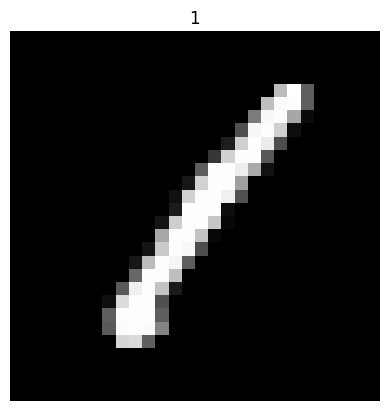

In [15]:
img = np.array(X_train.iloc[0]).reshape(28,28)
plt.imshow(img,cmap='gray')
plt.title(trainingData.iloc[0,0])
plt.axis("off")
plt.show()

In [16]:
def prepareInput(X):
    X = X.values.reshape(-1,28,28)
    X = torch.from_numpy(X)
    X = X.float()
    X = torch.unsqueeze(X, 1)#thêm 1 chiều cho dữ liệu
    return X
# chuyển sang tensor trong torch, thêm 1 chiều cho dữ liệu, phù hợp với đầu vào model
def prepareOutput(Y):
    Y = np.array(Y)
    Y = torch.from_numpy(Y)
    Y = one_hot(Y, num_classes=11).to(device=device)
    Y = Y.float()
    return Y
#mã hoá đầu ra

In [17]:
X_train = prepareInput(X_train)
X_train.shape

torch.Size([42000, 1, 28, 28])

In [18]:
Y_train = prepareOutput(Y_train)
Y_train.shape

torch.Size([42000, 11])

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_train, Y_train)
validation_split = 0.2
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)
print("Kích thước tập train:", len(train_dataset))
print("Kích thước tập validation:", len(val_dataset))


Kích thước tập train: 33600
Kích thước tập validation: 8400


In [20]:
#summary
model = OCR()
summary(model=model.to(device),input_size=(X_train[0].shape))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
            Conv2d-5           [-1, 32, 14, 14]           9,248
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          18,496
            Conv2d-8             [-1, 64, 7, 7]          36,928
         MaxPool2d-9             [-1, 64, 3, 3]               0
           Linear-10                  [-1, 256]         147,712
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 11]           2,827
Total params: 222,331
Trainable params: 222,331
Non-trainable params: 0
-------------------------------

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\ADMIN\Downloads\src code\python\Bib-Number-Recognition\model.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return softmax(features)


In [21]:
opt = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=1e-4)
crit = CrossEntropyLoss(reduction='mean')
sample_size = X_train.shape[0]
Y_train = Y_train.to(device=device)
from tqdm import tqdm
dataIter = iter(train_dataloader)
model = model.to(device)
model.train()
for t in tqdm(range(5000), ncols = 100):
    try:
        batch = next(dataIter)
    except StopIteration:
        dataIter = iter(train_dataloader)
        batch = next(dataIter)
    x_batch, y_batch = batch
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    opt.zero_grad()
    y_pred = model(x_batch)   #x is tensor of independent vars
    loss = crit(y_pred,y_batch) #y is tensor of outcomes
    if(t % 100 == 0):
        print(loss)            
    loss.backward()
    opt.step()


  0%|                                                                      | 0/5000 [00:00<?, ?it/s]

tensor(2.4013, grad_fn=<DivBackward1>)


  2%|█▍                                                         | 122/5000 [00:00<00:31, 152.74it/s]

tensor(2.1157, grad_fn=<DivBackward1>)


  5%|██▋                                                        | 229/5000 [00:01<00:27, 171.38it/s]

tensor(1.9136, grad_fn=<DivBackward1>)


  6%|███▊                                                       | 320/5000 [00:02<00:27, 170.17it/s]

tensor(2.0405, grad_fn=<DivBackward1>)


  9%|█████                                                      | 427/5000 [00:02<00:27, 168.48it/s]

tensor(1.7392, grad_fn=<DivBackward1>)


 10%|██████                                                     | 513/5000 [00:03<00:26, 167.71it/s]

tensor(1.8971, grad_fn=<DivBackward1>)


 12%|███████▎                                                   | 618/5000 [00:03<00:27, 161.73it/s]

tensor(1.7372, grad_fn=<DivBackward1>)


 14%|████████▌                                                  | 721/5000 [00:04<00:25, 169.03it/s]

tensor(1.8087, grad_fn=<DivBackward1>)


 16%|█████████▌                                                 | 811/5000 [00:04<00:26, 159.30it/s]

tensor(1.5431, grad_fn=<DivBackward1>)


 18%|██████████▊                                                | 919/5000 [00:05<00:29, 137.09it/s]

tensor(1.5751, grad_fn=<DivBackward1>)


 20%|███████████▊                                              | 1023/5000 [00:06<00:27, 142.19it/s]

tensor(1.7669, grad_fn=<DivBackward1>)


 22%|█████████████                                             | 1123/5000 [00:07<00:24, 159.40it/s]

tensor(1.5431, grad_fn=<DivBackward1>)


 24%|██████████████▏                                           | 1224/5000 [00:07<00:23, 158.13it/s]

tensor(1.7910, grad_fn=<DivBackward1>)


 26%|███████████████▎                                          | 1325/5000 [00:08<00:21, 167.94it/s]

tensor(1.6671, grad_fn=<DivBackward1>)


 28%|████████████████▌                                         | 1424/5000 [00:09<00:24, 147.20it/s]

tensor(1.5767, grad_fn=<DivBackward1>)


 30%|█████████████████▋                                        | 1521/5000 [00:09<00:23, 151.20it/s]

tensor(1.7299, grad_fn=<DivBackward1>)


 33%|██████████████████▊                                       | 1627/5000 [00:10<00:20, 166.33it/s]

tensor(1.6467, grad_fn=<DivBackward1>)


 34%|███████████████████▉                                      | 1718/5000 [00:11<00:19, 166.74it/s]

tensor(1.6657, grad_fn=<DivBackward1>)


 36%|█████████████████████                                     | 1818/5000 [00:11<00:22, 140.96it/s]

tensor(1.6713, grad_fn=<DivBackward1>)


 38%|██████████████████████▎                                   | 1925/5000 [00:12<00:21, 145.21it/s]

tensor(1.6684, grad_fn=<DivBackward1>)


 40%|███████████████████████▍                                  | 2025/5000 [00:13<00:19, 154.61it/s]

tensor(1.5826, grad_fn=<DivBackward1>)


 42%|████████████████████████▋                                 | 2123/5000 [00:13<00:17, 160.17it/s]

tensor(1.5460, grad_fn=<DivBackward1>)


 45%|█████████████████████████▊                                | 2227/5000 [00:14<00:16, 163.79it/s]

tensor(1.5433, grad_fn=<DivBackward1>)


 46%|██████████████████████████▉                               | 2321/5000 [00:15<00:22, 118.50it/s]

tensor(1.6675, grad_fn=<DivBackward1>)


 48%|████████████████████████████▍                              | 2412/5000 [00:16<00:32, 78.95it/s]

tensor(1.6035, grad_fn=<DivBackward1>)


 50%|█████████████████████████████▏                            | 2520/5000 [00:17<00:19, 126.91it/s]

tensor(1.6179, grad_fn=<DivBackward1>)


 52%|██████████████████████████████▍                           | 2621/5000 [00:17<00:17, 133.01it/s]

tensor(1.6681, grad_fn=<DivBackward1>)


 54%|███████████████████████████████▌                          | 2722/5000 [00:18<00:16, 136.52it/s]

tensor(1.7217, grad_fn=<DivBackward1>)


 56%|████████████████████████████████▊                         | 2824/5000 [00:19<00:16, 128.19it/s]

tensor(1.6055, grad_fn=<DivBackward1>)


 58%|█████████████████████████████████▊                        | 2918/5000 [00:20<00:15, 131.03it/s]

tensor(1.6027, grad_fn=<DivBackward1>)


 59%|██████████████████████████████████▍                       | 2965/5000 [00:20<00:14, 143.87it/s]


KeyboardInterrupt: 

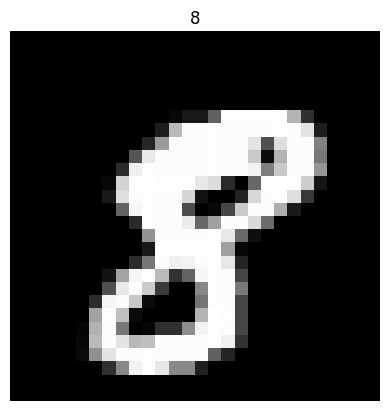

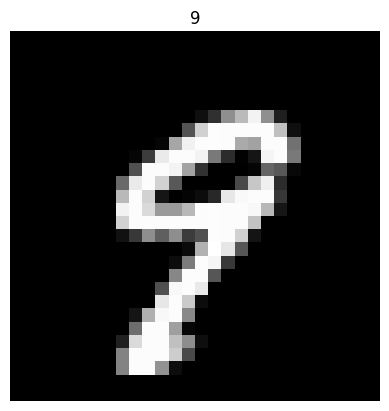

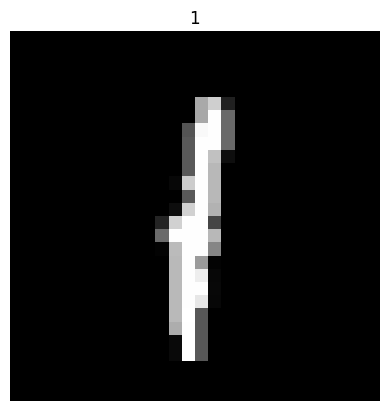

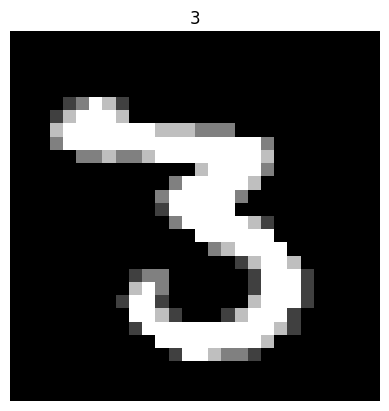

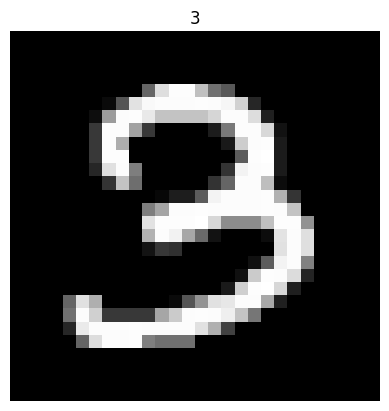

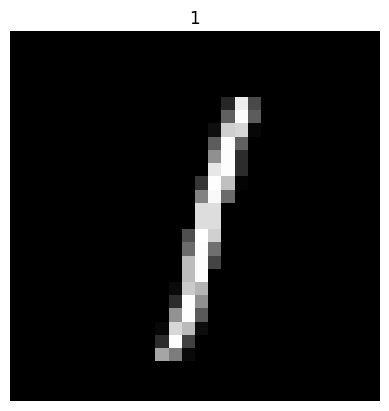

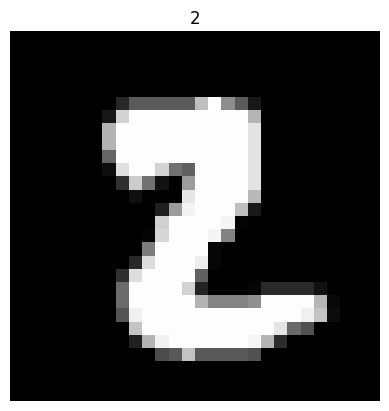

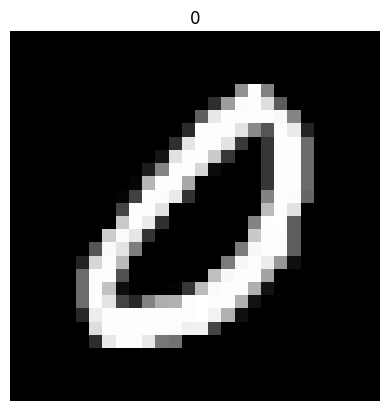

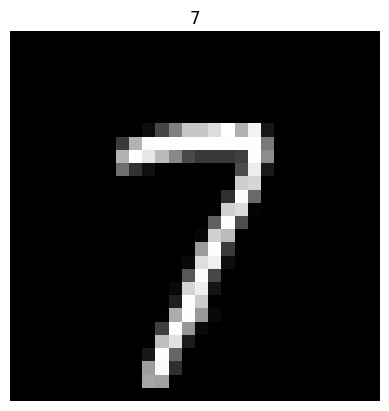

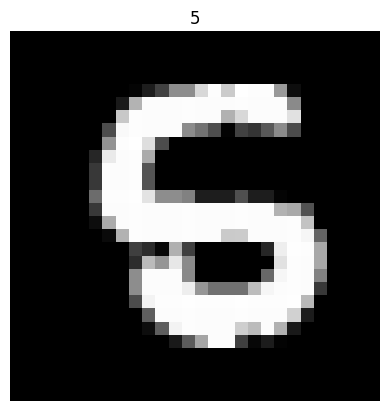

In [25]:
model = model.to('cpu')
model.eval()
with torch.no_grad():
    for id in range(10,20,1):
        img = X_train[id].to('cpu').numpy().reshape(28,28)
        plt.imshow(img,cmap='gray')
        plt.title(int(torch.argmax(model(X_train[id].to('cpu')))))
        plt.axis("off")
        plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [22]:
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>